In [15]:
from data_tools import query
from data_tools.collections import TimeSeries
import numpy as np
import matplotlib.pyplot as plt
from data_tools import FSGPDayLaps

day_3 = FSGPDayLaps(3)
start_time = day_3.get_start_utc(1)
stop_time = day_3.get_finish_utc(day_3.get_lap_count())
start_time, stop_time

(datetime.datetime(2024, 7, 18, 14, 17, 41, tzinfo=datetime.timezone.utc),
 datetime.datetime(2024, 7, 18, 21, 57, 5, tzinfo=datetime.timezone.utc))

In [16]:
client = query.DBClient()

speed: TimeSeries = client.query_time_series(start_time, stop_time, "VehicleVelocity")
accelator_percent: TimeSeries = client.query_time_series(start_time, stop_time, "AcceleratorPosition")
brake_pressed: TimeSeries = client.query_time_series(start_time, stop_time, "MechBrakePressed")
regen_enabled: TimeSeries = client.query_time_series(start_time, stop_time, "RegenEnabled")

In [17]:
acceleration = np.gradient(speed, speed.period)
accelator_percent, brake_pressed, regen_enabled, speed, acceleration = speed.align(accelator_percent, brake_pressed, regen_enabled, speed, acceleration)

cruising_mask = np.logical_and(
    np.asarray(brake_pressed) == 0,
    np.logical_and(accelator_percent == 0, speed > 1)
)

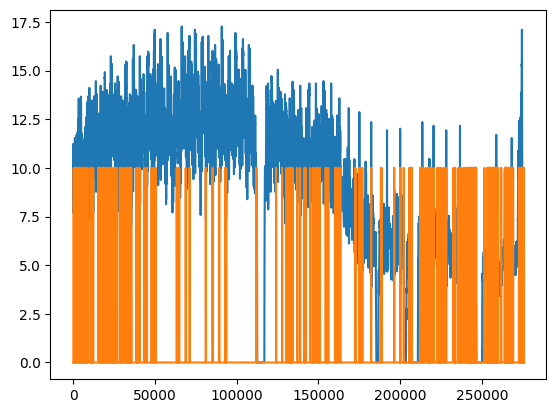

In [18]:
plt.plot(speed)
plt.plot(cruising_mask * 10)
plt.show()

In [19]:
car_mass_kg = 350

cruising_speeds = speed[cruising_mask]
cruising_forces = acceleration[cruising_mask] * car_mass_kg

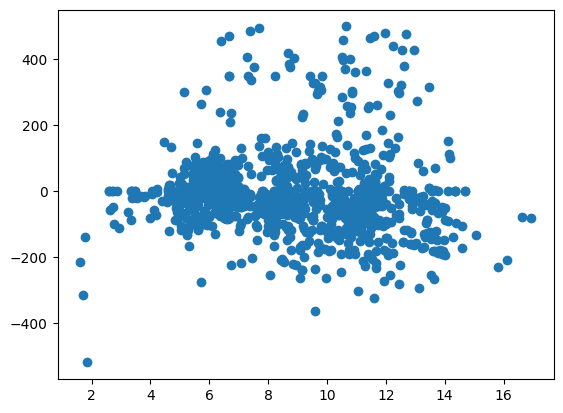

In [20]:
plt.scatter(cruising_speeds, cruising_forces)
plt.show()

In [21]:
sorted_indices = np.argsort(cruising_speeds)
sorted_speeds = cruising_speeds[sorted_indices]
sorted_forces = cruising_forces[sorted_indices]

From ubc-solar-physics BasicMotor.calculate_net_force:
```
required_speed_ms = required_speed_kmh / 3.6

acceleration_ms2 = np.clip(np.gradient(required_speed_ms), a_min=0, a_max=None)
acceleration_force = acceleration_ms2 * self.vehicle_mass

required_angular_speed_rads = required_speed_ms / self.tire_radius

drag_forces = 0.5 * self.air_density * (
        (required_speed_ms + wind_speeds) ** 2) * self.drag_coefficient * self.vehicle_frontal_area

angles = np.arctan(gradients)
g_forces = self.vehicle_mass * self.acceleration_g * np.sin(angles)

road_friction_array = self.road_friction * self.vehicle_mass * self.acceleration_g * np.cos(angles)

net_force = road_friction_array + drag_forces + g_forces + acceleration_force
```
Assuming we are driving on a flat surface, we get that `angles` are zero. Therefore:
```
-acceleration_force == drag_forces + road_friction_array
-acceleration_force == (0.5 * self.air_density * (
        (required_speed_ms + wind_speeds) ** 2) * self.drag_coefficient * self.vehicle_frontal_area) + (self.road_friction * self.vehicle_mass * self.acceleration_g)
```

We roughly have:

$F_{drag}=\frac12 \rho v^2 C_D A$

$F_{road_friction} = C_R w = C_R m g$

with:

road_friction = 0.012

vehicle_frontal_area = 1.1853

drag_coefficient = 0.11609

In [22]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

road_friction = 0.012
vehicle_frontal_area = 1.1853
drag_coefficient = 0.11609
AIR_DENSITY = 1.225

def cruising_forces_fit_func(v, drag_scale=1, friction_scale=1):
    drag_force = 0.5 * AIR_DENSITY * drag_coefficient * vehicle_frontal_area * v**2
    rolling_friction_force = car_mass_kg * 9.81 * road_friction
    return -drag_force * drag_scale - rolling_friction_force * friction_scale

In [23]:
popt, pcov  = curve_fit(cruising_forces_fit_func, sorted_speeds, sorted_forces)
drag_scale, friction_scale = popt
drag_scale, friction_scale

(np.float64(2.707425743965639), np.float64(-0.22212334604291306))

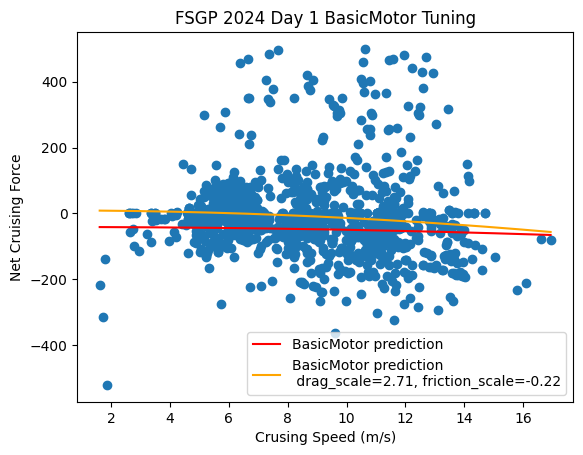

In [25]:
plt.scatter(sorted_speeds, sorted_forces)
plt.plot(sorted_speeds, cruising_forces_fit_func(sorted_speeds, 1, 1), color='red', label="BasicMotor prediction")
plt.plot(sorted_speeds, cruising_forces_fit_func(sorted_speeds, drag_scale, friction_scale), color='orange', label=f"BasicMotor prediction\n drag_scale={drag_scale:.2f}, friction_scale={friction_scale:.2f}")
plt.legend(loc="best")
plt.title("FSGP 2024 Day 1 BasicMotor Tuning")
plt.ylabel("Net Cruising Force")
plt.xlabel("Crusing Speed (m/s)")
plt.show()

In [26]:
import scipy.optimize as opt

def mean_squared_error(args) -> float:
    sum = 0
    for speed, force in zip(sorted_speeds, sorted_forces):
        sum += (cruising_forces_fit_func(speed, *args) - force) ** 2
    return sum / (len(sorted_speeds) - 1)

bounds = [(0, 4), (0, 2)]  # drag_scale, friction_scale

opt_result = opt.differential_evolution(mean_squared_error, bounds)
opt_result.x

array([1.73745709, 0.        ])

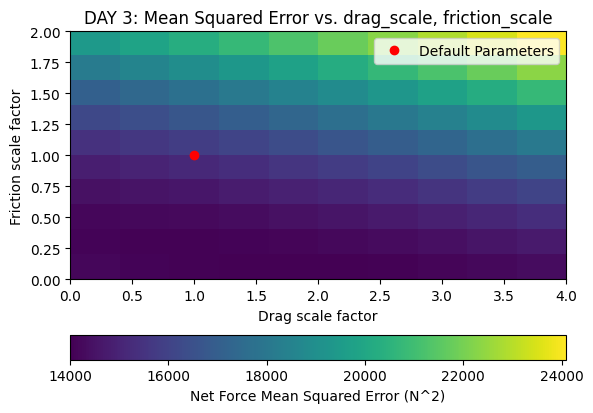

In [29]:
def plot_drag_friction_scale_vs_mae():
    x_vals = np.linspace(bounds[0][0], bounds[0][1], 10)
    y_vals = np.linspace(bounds[1][0], bounds[1][1], 10)

    X, Y = np.meshgrid(x_vals, y_vals)
    coords = np.stack((X, Y), axis=-1)
    result = np.empty(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            result[i, j] = mean_squared_error(coords[i, j])

    plt.imshow(result, extent=(*bounds[0], *bounds[1]), origin='lower')
    plt.colorbar(location="bottom", label="Net Force Mean Squared Error (N^2)")
    plt.title(r'DAY 3: Mean Squared Error vs. drag_scale, friction_scale')
    plt.xlabel(r'Drag scale factor')
    plt.ylabel(r'Friction scale factor')
    plt.plot(1, 1, 'ro', label="Default Parameters")
    plt.legend()
    plt.show()

plot_drag_friction_scale_vs_mae()